<img src="https://raw.githubusercontent.com/earthdaily/Images/main/Corporate/EarthDaily.png" width="20%" alt="EarthDaily Analytics">

# Comparing EarthMosaics to Sentinel-2 Imagery
__________________
<a href="https://earthdaily.com/contact/">Give Feedback</a> | <a href="https://github.com/earthdaily">Bug report</a>

**Tags:** #EDS, #EarthMosaics, #Sentinel-2

**Authors**: EarthDaily Analytics

**Last update:** 2024-11-26 (Created: 2024-11-18)

**References:**
- [EarthDaily package](https://github.com/earthdaily/earthdaily-python-client)
- [Earth Data Store documentation](https://earthdaily.github.io/EDA-Documentation/)
- [Xarray as multi-dimensional object](https://docs.xarray.dev/en/stable/)

## Introduction

Cloud-cover is a significant obstructor when it comes to analyzing and interpreting signals from remote sensing data, especially in tropical regions with often unpredictable weather patterns. [EarthDaily EarthMosaics](https://earthdaily.com/product-service/earthmosaics/) provide temporally coherent, cloud-free imagery fusing [Landsat](https://www.usgs.gov/landsat-missions/landsat-collection-2-level-1-data) and [Sentinel-2](https://sentinels.copernicus.eu/web/sentinel/sentinel-data-access/sentinel-products/sentinel-2-data-products/collection-1-level-2a) mission data resulting in much higher signal-to-noise compared to using these data sources independently. 

This example provides a detailed look at a year's timeseries of Normalized Difference Vegetation Index (NDVI) at a sample field in Rio Grande do Sul, Brazil. This sample is meant to demonstrate the value of clean, cloud-free timeseries analysis and should not act as a robust agriculural health study.

## Objectives

By the end of this analysis, we will have compared EarthMosaic- and Sentinel-2-derived NDVI throughout 2024. This includes:
* **Data Acquisition**: Query and retrieve stacks of multispectral data.
* **Visualization**: Visualize RGB imagery through 2024.
* **Cloud Masking**: Using the Sentinel-2 SCL band, label each image as cloudy or cloud-free.
* **Timeseries Data Generation and Export**: Summarize NDVI values through the input time period. 

## Data Description

We utilize satellite imagery from the EarthDataStore, specifically the **AI-Ready Mosaics Collection**, generated using the [EarthDaily EarthMosaics](https://earthdaily.com/product-service/earthmosaics/) service using Landsat and Sentinel-2 imagery. The imagery includes the **BLUE**, **GREEN**, **NIR0.8**, and **RED** bands, essential for computing Normalized Difference Vegetation Index (NDVI).

## Methodology

### Normalized Difference Vegetation Index (NDVI) 
The [NDVI](https://ntrs.nasa.gov/citations/19740022614) formula is a common technique used to highlight healthy, growing vegetation in a scene. It is calculated using:
* **Near-Infrared Band (842nm)**: Sensitive to chlorophyll content in growing vegetation.
* **Red (665nm)**: Sensitive to all vegetation.

Higher NDVI values correspond to healthier vegetation.

### Timeseries Data Procedure
1. **Data Discovery and Image Loading**: Retrieve EarthMosaics and Sentinel-2 Items through a [STAC Client search](https://pystac-client.readthedocs.io/en/stable/usage.html#client) and load as [`Xarray Datasets`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) through [`odc.stac.load`](https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html).
2. **Index Calculation**: Calculate NDVI for each scene within our stack of imagery.
3. **Summary Statistics**: Calculate the mean NDVI for each date, plot and save results for external use. 

## Environment Setup

We start by setting up the environment and loading the necessary libraries, including geospatial libraries like [GeoPandas](https://geopandas.org/en/stable/docs/reference.html) and [Rasterio](https://rasterio.readthedocs.io/en/stable/).

We then:

- **Load Environment Variables**: Access API keys and other configurations.
- **Authenticate and Initialize STAC Client**: Connect to the data source for querying and retrieving satellite imagery.
- **Declare Global Variables**: Such as the input Collections, a list of Bands, output Resolution, and a Bounding Box to clip to,

### Import dependencies

In [1]:
import os
import requests

import numpy as np
import pandas as pd
import xarray as xr

from datetime import datetime, timedelta
from dotenv import load_dotenv
from pystac_client import Client

from odc.stac import stac_load

from matplotlib import pyplot as plt

### Authentication 
Defining one helper function, which retrieves an access token from the EarthDaily API* given provided environment variables:
* *EDS_AUTH_URL*
* *EDS_API_URL*
* *EDS_CLIENT_ID*
* *EDS_CLIENT_SECRET*

*_For more information please navigate to the [EarthDaily Account Management page](https://console.earthdaily.com/account)_

In [2]:
def get_new_token(session):
    """Obtain a new authentication token using client credentials."""
    token_req_payload = {"grant_type": "client_credentials"}
    try:
        token_response = session.post(AUTH_TOKEN_URL, data=token_req_payload)
        token_response.raise_for_status()
        tokens = token_response.json()
        return tokens["access_token"]
    except requests.exceptions.RequestException as e:
        print(f"Failed to obtain token: {e}")

Loading in environment variables, please update the associated [`EDS.env`](EDS.env), which can be downloaded from the [EarthDaily Account Management page](https://console.earthdaily.com/account).

In [3]:
load_dotenv("EDS.env")  # take environment variables from .env.

True

> _**Note:**_ To gain access to the Earth Data Store data used in this example, please [create an EarthDaily account](https://console.earthdaily.com/mosaics/signup)

> _**Note:**_ To gain access to the Earth Data Store data used in this example, please [create an EarthDaily account](https://console.earthdaily.com/mosaics/signup)

In [4]:
CLIENT_ID = os.getenv("EDS_CLIENT_ID")
CLIENT_SECRET = os.getenv("EDS_SECRET")
AUTH_TOKEN_URL = os.getenv("EDS_AUTH_URL")
API_URL = os.getenv("EDS_API_URL")

Setting up a requests [`Session`](https://requests.readthedocs.io/en/latest/api/#requests.Session) to retrieve an access token:

In [5]:
session = requests.Session()
session.auth = (CLIENT_ID, CLIENT_SECRET)
token = get_new_token(session)

### Connect to STAC Client
Next we'll establish a [PySTAC `Client`](https://pystac-client.readthedocs.io/en/stable/api.html#pystac_client.Client) connection to the EarthDaily STAC API and construct two queries to retrieve Sentinel-2 L2A and Venus L2A image collections which correspond to a defined bounding box and start/end dates. 

In [ ]:
catalog = Client.open(
    API_URL,  
    headers={
         "Authorization": f"bearer {token}",
         "X-Signed-Asset-Urls": "true",
    }
)
catalog

<Client id=stac-fastapi>

### Declare Variables
Query parameters for the specific item, including STAC Collection IDs, start/end dates, a list of bands to retrieve, and an acceptable image-wise cloud percentage:

In [ ]:
S2_COLLECTION = "sentinel-2-l2a"
MOSAIC_COLLECTION = "ai-ready-mosaics-sample"
BANDS=("red", "green", "blue","nir08")
# Set a start and end date
start_date = "2024-01-01"
end_date = "2024-11-01"
max_clouds = 50 # the maximum cloud cover percentage. Note this is over the WHOLE image, not just the ROI

Bounding box to search and clip imagery to:

In [8]:
bbox = [-53.98508699966091, -29.553030644503163, -53.98340355613824, -29.55150003325548]
bbox

[-53.98508699966091,
 -29.553030644503163,
 -53.98340355613824,
 -29.55150003325548]

Defining a function which filters out duplicate dates from a search result:

In [9]:
def filter_duplicates(items, time_tolerance=timedelta(minutes=5)):
    # Filters items based on acquisition time with a given time tolerance. Useful for getting rid of duplicates
    # from overlapping Sentinel-2 tiles
    unique_items = []
    seen_times = []
    for item in items:
        acquisition_time = item.datetime
        is_duplicate = any([abs(acquisition_time - seen_time) < time_tolerance for seen_time in seen_times])
        if not is_duplicate:
            unique_items.append(item)
            seen_times.append(acquisition_time)
    return unique_items

_**Note:** The following function replaces each STAC Item's default href with an alternate presigned URL. This allows for access to the data directly without the need for an AWS account._

In [ ]:
def replace_alternate_href(items):
  for item in items:
    for asset_key, asset in item.assets.items():
        item.assets[asset_key].href = item.assets[asset_key].extra_fields["alternate"]["download"]["href"]
  return items

## Loading Satellite Data
Below we will:
* [Search Sentinel-2 Collection](https://pystac-client.readthedocs.io/en/stable/api.html#pystac_client.Client.search) for imagery over our AOI and TOI, including a max_cloud percentage
* Use [`stac_load`](https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html) to retrieve an [`xarray Dataset`](https://docs.xarray.dev/en/stable/), which includes: 
    - **Band Selection**: We focus on key spectral bands—green, near-infrared, red, and swir16—which are later used for calculating NDVI-MNDWI
    - **CRS and Resolution**: We reproject the data to `EPSG:3857` to work with a 100-meter spatial resolution.

### EarthMosaics Search

In [ ]:
mosaic_query = catalog.search(
    collections=[MOSAIC_COLLECTION],
    datetime=f"{start_date}/{end_date}",
    bbox=bbox,
)
mosaic_items = list(mosaic_query.items())
mosaic_filt_items = filter_duplicates(mosaic_items)
mosaic_filt_items = replace_alternate_href(mosaic_filt_items)

print(f"Found {len(mosaic_items)} total items in ai-ready-mosaics-sample")
print(f"Filtered to {len(mosaic_filt_items)} unique items")

Found 29 total items in sentinel-2-l2a
Filtered to 27 unique items


### Sentinel-2 Search

In [11]:
s2_query = catalog.search(
    collections=[S2_COLLECTION],
    datetime=f"{start_date}/{end_date}",
    bbox=bbox,
    query={"eo:cloud_cover":{"lt":max_clouds}},
)
s2_items = list(s2_query.items())
s2_filt_items = filter_duplicates(s2_items)
print(f"Found {len(s2_items)} total items in sentinel-2-l2a")
print(f"Filtered to {len(s2_filt_items)} unique items")

Found 101 total items in sentinel-2-l2a
Filtered to 56 unique items


### Load Xarray Datasets
#### EarthMosaics

In [12]:
mosaic_dataset = stac_load(
    mosaic_filt_items,
    bands=BANDS,
    crs="epsg:3857", 
    resolution=5.,
    chunks={"x":2048, "y":2048},
    groupby="id",
    bbox=bbox
)
mosaic_dataset

<xarray.Dataset> Size: 657kB
Dimensions:      (y: 40, x: 38, time: 27)
Coordinates:
  * y            (y) float64 320B -3.446e+06 -3.446e+06 ... -3.446e+06
  * x            (x) float64 304B -6.01e+06 -6.01e+06 ... -6.009e+06 -6.009e+06
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 216B 2024-10-21T13:30:49.272290 ... 20...
Data variables:
    red          (time, y, x) float32 164kB dask.array<chunksize=(1, 40, 38), meta=np.ndarray>
    green        (time, y, x) float32 164kB dask.array<chunksize=(1, 40, 38), meta=np.ndarray>
    blue         (time, y, x) float32 164kB dask.array<chunksize=(1, 40, 38), meta=np.ndarray>
    nir08        (time, y, x) float32 164kB dask.array<chunksize=(1, 40, 38), meta=np.ndarray>

Sample plot of image within the dataset:

Text(0.5, 1.0, '2024-10-21')

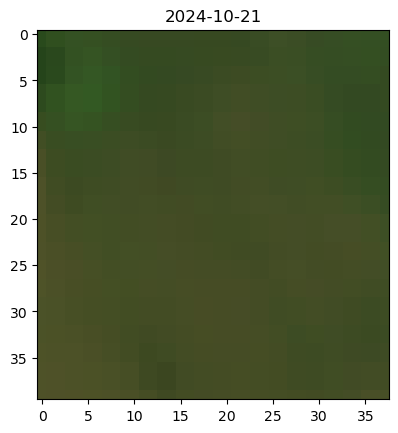

In [13]:
mos_ds = mosaic_dataset.isel(time=0)
mos_arr = np.stack(
    [mos_ds['red'].values, mos_ds['green'].values, mos_ds['blue'].values], 
    axis=-1
)

mos_arr-=1000
mos_arr = np.clip(mos_arr, 0, 2000)
mos_arr = mos_arr/2000.

plt.imshow((mos_arr*255).astype(np.uint8))
plt.title(pd.Timestamp(mos_ds.time.values).strftime("%Y-%m-%d"))

#### Sentinel-2 

In [14]:
s2_dataset = stac_load(
    s2_filt_items,
    bands=BANDS,
    crs="epsg:3857", 
    resolution=5.,
    chunks={"x":2048, "y":2048},
    groupby="id", 
    bbox=bbox
)
s2_dataset

<xarray.Dataset> Size: 682kB
Dimensions:      (y: 40, x: 38, time: 56)
Coordinates:
  * y            (y) float64 320B -3.446e+06 -3.446e+06 ... -3.446e+06
  * x            (x) float64 304B -6.01e+06 -6.01e+06 ... -6.009e+06 -6.009e+06
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 448B 2024-10-31T13:50:37.605000 ... 20...
Data variables:
    red          (time, y, x) uint16 170kB dask.array<chunksize=(1, 40, 38), meta=np.ndarray>
    green        (time, y, x) uint16 170kB dask.array<chunksize=(1, 40, 38), meta=np.ndarray>
    blue         (time, y, x) uint16 170kB dask.array<chunksize=(1, 40, 38), meta=np.ndarray>
    nir08        (time, y, x) uint16 170kB dask.array<chunksize=(1, 40, 38), meta=np.ndarray>

Text(0.5, 1.0, '2024-10-31')

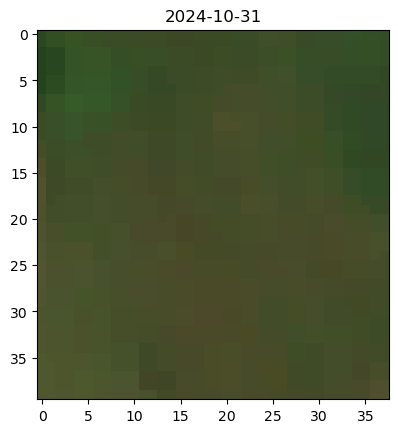

In [15]:
s2_ds = s2_dataset.isel(time=0)
s2_arr = np.stack(
    [s2_ds['red'].values, s2_ds['green'].values, s2_ds['blue'].values], 
    axis=-1
)

s2_arr = np.clip(s2_arr, 0, 2000)
s2_arr = s2_arr/2000.

plt.imshow((s2_arr*255).astype(np.uint8))
plt.title(pd.Timestamp(s2_ds.time.values).strftime("%Y-%m-%d"))

#### Sentinel-2 SCL Band
Below we retrieve Sentinel-2's Scene Classification Layer (SCL) band to perform a quality assessment on the pixel-level. 

In [16]:
s2_scl_dataset = stac_load(
    s2_filt_items,
    bands=("scl",),  # Only load the scl band here
    crs="epsg:3857", 
    resolution=5, 
    chunks={'x': 2048, 'y': 2048},
    groupby="id",
    bbox=bbox,
)
s2_scl_dataset

<xarray.Dataset> Size: 86kB
Dimensions:      (y: 40, x: 38, time: 56)
Coordinates:
  * y            (y) float64 320B -3.446e+06 -3.446e+06 ... -3.446e+06
  * x            (x) float64 304B -6.01e+06 -6.01e+06 ... -6.009e+06 -6.009e+06
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 448B 2024-10-31T13:50:37.605000 ... 20...
Data variables:
    scl          (time, y, x) uint8 85kB dask.array<chunksize=(1, 40, 38), meta=np.ndarray>

#### _Note_: 
See [Table 68 here](https://sentinels.copernicus.eu/documents/d/sentinel/s2-pdgs-cs-di-psd-v15-0) for more information on Sentinel-2 L2A SCL band values:

In [17]:
s2_cloud_values = [0, 3, 8, 9, 10]

# Create a mask where scl values indicate clouds, and calculate percentage cloud
s2_cloud_mask = s2_scl_dataset['scl'].isin(s2_cloud_values)
s2_cloud_fraction = s2_cloud_mask.mean(dim=('x', 'y'))  # Fraction of cloud-covered pixels per time slice

# Filter the scl dataset by cloud-free time slices (e.g., cloud fraction < 1% cloud cover)
s2_cloud_free_indices = (s2_cloud_fraction < 0.000001)
s2_dataset['cloud_free']=s2_cloud_free_indices
s2_cloud_free_items = np.array(s2_filt_items)[s2_cloud_free_indices].tolist()
s2_cloudy_items = np.array(s2_filt_items)[~s2_cloud_free_indices].tolist()

print(f'Out of {len(s2_filt_items)} items found {len(s2_cloud_free_items)} cloud-free items')

/home/ubuntu/miniconda3/envs/earthdaily/lib/python3.12/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Out of 56 items found 43 cloud-free items


## Calculate NDVI

In [18]:
mosaic_meanval = mosaic_dataset.mean(('x','y'))-1000
mosaic_meanval.attrs['sensor'] = "EarthMosaics"

mosaic_ndvi = (mosaic_meanval["nir08"] - mosaic_meanval["red"]) / (mosaic_meanval["nir08"] + mosaic_meanval["red"])
mosaic_meanval["ndvi"] = mosaic_ndvi

mosaic_meanval = mosaic_meanval.load()

mosaic_meanval

<xarray.Dataset> Size: 760B
Dimensions:      (time: 27)
Coordinates:
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 216B 2024-10-21T13:30:49.272290 ... 20...
Data variables:
    red          (time) float32 108B 496.4 484.4 500.1 ... 269.8 264.9 292.2
    green        (time) float32 108B 606.0 616.8 643.7 ... 455.0 447.4 476.8
    blue         (time) float32 108B 285.0 298.2 309.6 ... 197.9 191.7 216.3
    nir08        (time) float32 108B 3.177e+03 3.246e+03 ... 5.1e+03 5.245e+03
    ndvi         (time) float32 108B 0.7297 0.7403 0.7363 ... 0.9012 0.8945
Attributes:
    sensor:   EarthMosaics

In [19]:
s2_meanval = s2_dataset.mean(('x','y'))
s2_meanval.attrs['sensor'] = "Sentinel2"

s2_ndvi = (s2_meanval["nir08"] - s2_meanval["red"]) / (s2_meanval["nir08"] + s2_meanval["red"])
s2_meanval["ndvi"] = s2_ndvi

s2_meanval = s2_meanval.load()

s2_meanval

<xarray.Dataset> Size: 3kB
Dimensions:      (time: 56)
Coordinates:
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 448B 2024-10-31T13:50:37.605000 ... 20...
Data variables:
    red          (time) float64 448B 518.2 516.4 4.17e+03 ... 456.3 587.0
    green        (time) float64 448B 606.7 683.8 4.307e+03 ... 678.1 866.7
    blue         (time) float64 448B 318.7 366.3 4.47e+03 ... 360.3 558.6
    nir08        (time) float64 448B 3.07e+03 3.434e+03 ... 5.214e+03 5.272e+03
    cloud_free   (time) bool 56B True True False True ... True False True True
    ndvi         (time) float64 448B 0.7112 0.7386 0.1002 ... 0.8391 0.7996
Attributes:
    sensor:   Sentinel2

### Plot NDVI

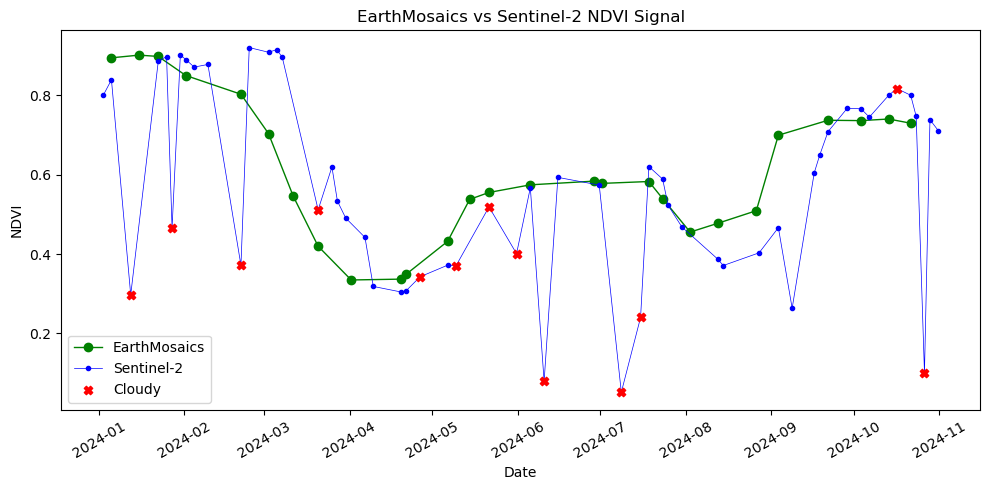

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
plt.title("EarthMosaics vs Sentinel-2 NDVI Signal")
s2_cloudy = s2_meanval.where(~s2_meanval['cloud_free'])

ax.plot(mosaic_meanval['time'], mosaic_meanval['ndvi'], lw=1, color='g', marker='o')
ax.plot(s2_meanval['time'], s2_meanval['ndvi'], lw=0.5, color='b', marker='.')
ax.scatter(s2_cloudy['time'], s2_cloudy['ndvi'], color='r', marker='X', zorder=2)
plt.legend(['EarthMosaics', 'Sentinel-2', 'Cloudy'])
plt.ylabel("NDVI")
plt.xlabel("Date")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("em_vs_s2_ndvi.png")

## Discussion of Results
Note the irregularity of quality and overall noisiness of Sentinel-2 coverage throughout the year. EarthMosaics compensates for these gaps by incorporate multple sensors (e.g. Landsat 8/9) and ensures a spectrally coherent signal no matter the season. 

## Plot Input Imagery
_Note: The following 2 cells will take a few minutes each to run, as they plot each image individually._

### Mosaics

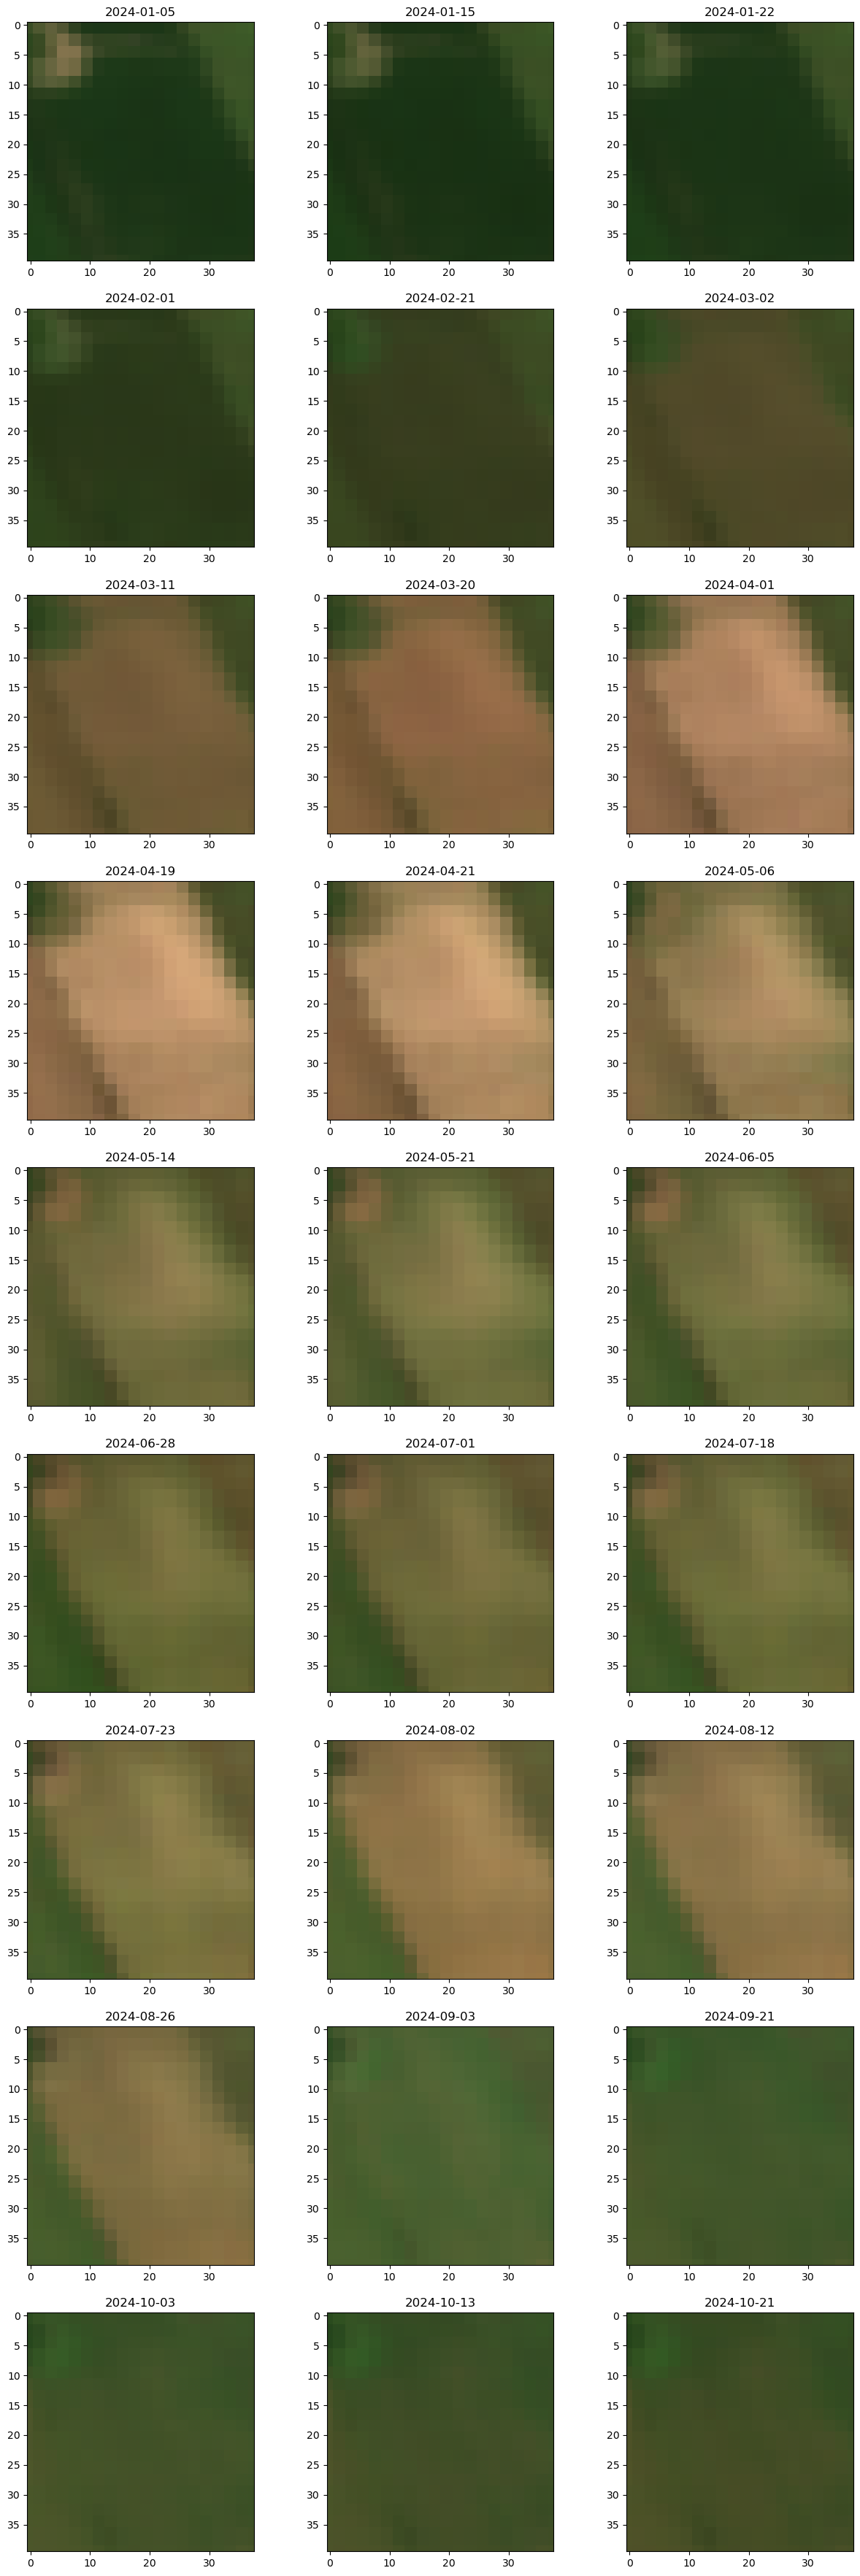

In [21]:
ncols, nrows = 3, (len(mosaic_dataset.time)+2)//3
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5*nrows))
for i, mos_time in list(enumerate(mosaic_dataset.sortby('time').time)):
    mos_ds = mosaic_dataset.sortby('time').isel(time=i)
    row = i//ncols
    col = i % ncols
    ax = axes[row, col]
    mos_arr = np.stack(
        [mos_ds['red'].values, mos_ds['green'].values, mos_ds['blue'].values], 
        axis=-1
    )
    mos_arr-=1000
    mos_arr = np.clip(mos_arr, 0, 2000)
    mos_arr = mos_arr/2000.
    mos_date = pd.Timestamp(mos_time.values).strftime('%Y-%m-%d')
    ax.imshow((mos_arr*255).astype(np.uint8))
    ax.set_title(mos_date)

plt.savefig("mosaics.png")
plt.show()

### Sentinel-2
_Additionally labeling each image as Cloudfree/Not Cloudfree._

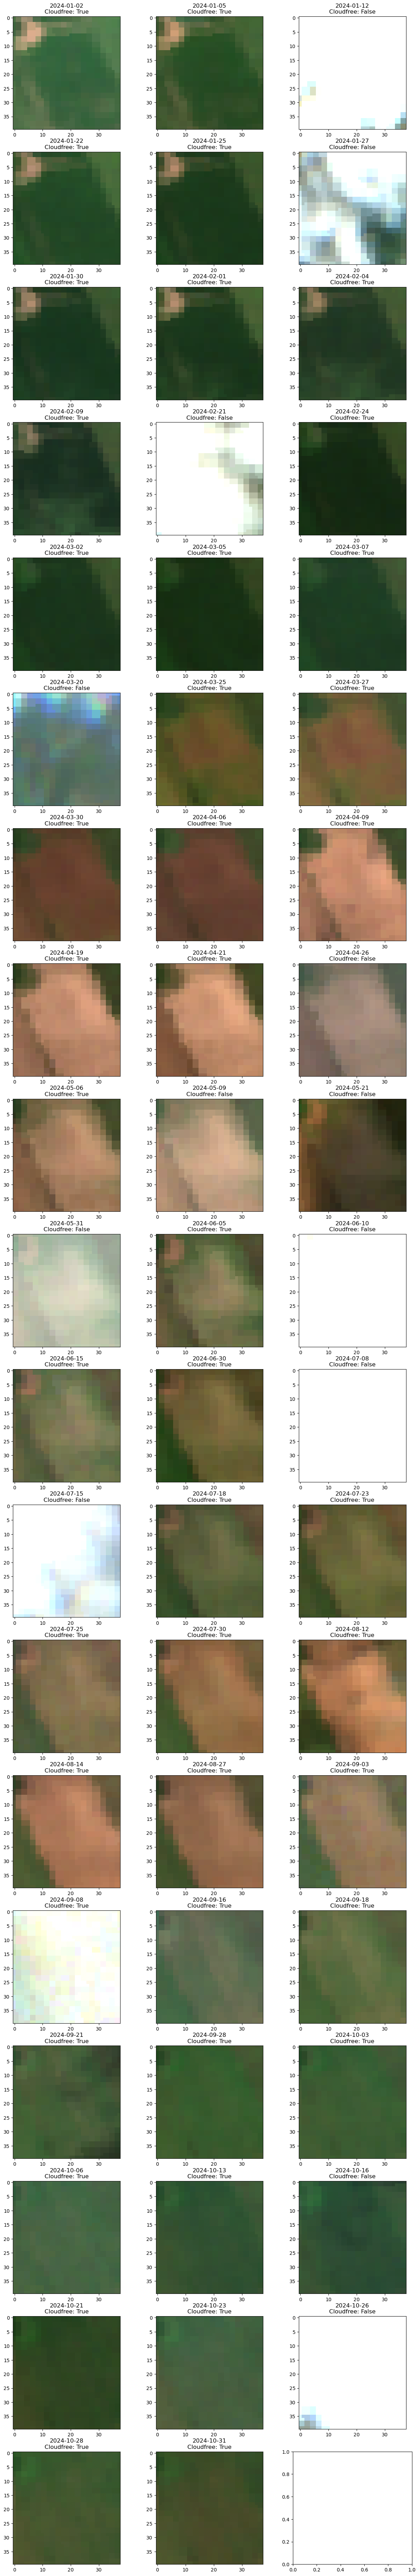

In [22]:
ncols, nrows = 3, (len(s2_dataset.time)+2)//3
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5*nrows))
for i, s2_time in list(enumerate(s2_dataset.sortby('time').time)):
    s2_ds = s2_dataset.sortby('time').isel(time=i)
    row = i//ncols
    col = i % ncols
    ax = axes[row, col]
    s2_arr = np.stack(
        [s2_ds['red'].values, s2_ds['green'].values, s2_ds['blue'].values], 
        axis=-1
    )
    s2_arr = np.clip(s2_arr, 0, 2000)
    s2_arr = s2_arr/2000.
    s2_date = pd.Timestamp(s2_time.values).strftime('%Y-%m-%d')
    ax.imshow((s2_arr*255).astype(np.uint8))
    ax.set_title(s2_date+f"\nCloudfree: {str(s2_ds['cloud_free'].values)}")

plt.savefig("sentinel2.png")
plt.show()

### Save NDVI Results

In [23]:
import pickle
# Open the file in binary mode
with open('meanval_s2.pickle', 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(s2_meanval, file)
    file.close()

# Open the file in binary mode
with open('meanval_mosaic.pickle', 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(mosaic_meanval, file)
    file.close()

### _Cleaning Up_

In [24]:
os.remove('meanval_s2.pickle')
os.remove('meanval_mosaic.pickle')
os.remove('mosaics.png')
os.remove('sentinel2.png')
os.remove('em_vs_s2_ndvi.png')